<a href="https://colab.research.google.com/github/AngelMaximiliano0/DolphinDetector/blob/main/DolphinDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test Dolphin Detector

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Conecto GDrive

In [ ]:
# Rutas de entrada
image_path = "/content/drive/MyDrive/Colab_Notebooks/Detector/YOLODataset/images/train"
labels_path = "/content/drive/MyDrive/Colab_Notebooks/Detector/YOLODataset/labels/train"

# Rutas de salida
output_path = "/content/drive/MyDrive/Colab_Notebooks/Detector"

##Ver dataset

#### Importe librerías

In [ ]:
#Librerías a usar
import matplotlib.pyplot as plt  #Permite generar gráficos y visualizarlos (la llamé plt)
import matplotlib.image as mpimg #Permite leer y manipular imagenes (la llamé mpimg)
import os                        #Interactua con el SO, construyendo las rutas de acceso
import json                      #Permite trabajar con archivos JSON
import matplotlib.patches as patches #Permite crear formas geométricas sobre la imagen
from PIL import Image            #Image desde PILLOW: Abre, manipula y guarda imágenes.


###Ver imagen

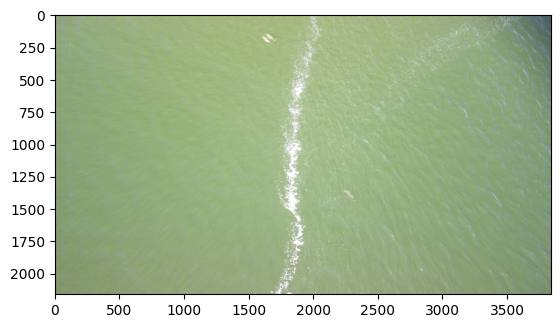

In [ ]:
# Crea la ruta completa a la imagen
ruta_imagen = os.path.join(image_path, "DJI_0019_047.jpeg") #Permite definir ruta y buscar imágen

# Carga la imagen usando matplotlib.image.imread
imagen = mpimg.imread(ruta_imagen)

# Muestra la imagen usando matplotlib.pyplot.imshow
plt.imshow(imagen)
plt.axis('on')  # Muestra los ejes
plt.show()

###Visualizar datos

In [ ]:
#Visualización de imagen con respectivo BBOX para archivos json

nombre_imagen = "DJI_0019_047.jpeg" #La transformo en variable para ser usada en la función siguiente

# Crea la ruta completa a la imagen y al archivo JSON
ruta_imagen = os.path.join(image_path, nombre_imagen)
ruta_json = os.path.join(labels_path, nombre_imagen[:-4] + '.json)  # Asume que el archivo JSON tiene el mismo nombre que la imagen pero con extensión .json

imagen = Image.open(ruta_imagen) #Abre la imagen con PILL

# Carga el archivo JSON
with open(ruta_json, 'r') as f:  #Abre un JSON, lee (r). Usa with para cerrar el bloque. JSON -> f. Lo carga en una variable
    datos_json = json.load(f)     #Carga F en datos_json

# Crea una figura y un eje usando matplotlib
fig, ax = plt.subplots(1)  #fig controla aspectos de la figura. ax es la variable que se dibuja en el subplot (1)

# Muestra la imagen en el eje
ax.imshow(imagen)  #Muestra la imagen en el eje

# Dibuja los bounding boxes
for shapes in datos_json['shapes']:  #Recorre los shapes del JSON que contiene las características mencionadas, asignandolas a var
    points = shapes['points']
    label = shapes['label']

#Crear rectángulo
    x, y = points[0]  #Desempaqueta los valores x e y de points asignandolos
    width = points[1][0] - points[0][0] #define ancho del rectángulo en base a points
    height = points[1][1] - points[0][1]  #define el alto del rectángulo en base a points
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='g', facecolor='none')

#Agregar rectángulo y etiquetas al eje:
###El problema de no visualización de los rectángulos estaba dado porque dejé fuera del loop las funciones que siguen.
    ax.add_patch(rect)
    ax.text(x, y, label, color='r', fontsize=10, ha = "left", va = "center")

# Oculta los ejes
plt.axis('on')
# Muestra la imagen con los bounding boxes
plt.show()




Probar modelo

#Pre-procesamiento

In [ ]:
#Para conocer las características de un video
import cv2

def obtener_info_video(ruta_video):
    video = cv2.VideoCapture(ruta_video)

    if not video.isOpened():
        print("Error: No se pudo abrir el video.")
        return None

    info = {
        "FPS": video.get(cv2.CAP_PROP_FPS),  # Cuadros por segundo
        "Total de frames": int(video.get(cv2.CAP_PROP_FRAME_COUNT)),  # Cantidad de cuadros totaltes
        "Duración (s)": round(video.get(cv2.CAP_PROP_FRAME_COUNT) / video.get(cv2.CAP_PROP_FPS), 2) if video.get(cv2.CAP_PROP_FPS) > 0 else None, #Duración total
        "Resolución (ancho x alto)": (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))),  #Resolución
        "Codec": int(video.get(cv2.CAP_PROP_FOURCC)),  # Código del códec en formato entero
        "Tasa de bits (kbps)": round(video.get(cv2.CAP_PROP_BITRATE) / 1000, 2) if video.get(cv2.CAP_PROP_BITRATE) > 0 else "No disponible"
    }

    # Decodificar el códec en texto legible
    codec = "".join([chr((info["Codec"] >> (8 * i)) & 0xFF) for i in range(4)])
    info["Codec"] = codec if codec.strip() else "No disponible"

    video.release()

    return info

# Ruta del video
ruta_video = "/content/drive/MyDrive/Detector/Prueba_Modelo/video.mp4"  # Reemplázalo con tu archivo de video

# Obtener información
info_video = obtener_info_video(ruta_video)

# Mostrar resultados
if info_video:
    for clave, valor in info_video.items():
        print(f"{clave}: {valor}")


FPS: 10.0
Total de frames: 206
Duración (s): 20.6
Resolución (ancho x alto): (1920, 1080)
Codec: FMP4
Tasa de bits (kbps): 8.76


reducción fps

#Procesamiento

### Reducción de FPS RATE

In [ ]:
import cv2  #Open Source Computer Vision Library (y ML)
import os  # Operation System permite la manipulación de archivos
from google.colab import files

# Función para crear carpeta si no existe
def crear_carpeta(ruta):
    os.makedirs(ruta, exist_ok=True)
    return ruta

#Ruta de video
ruta_video = "/content/drive/MyDrive/Detector/Prueba_Modelo/video.mp4"
nombre_original = os.path.basename(ruta_video)

# Configuración del usuario
nombre_salida = input("Nombre del video resultante (ej: video_10fps.mp4): ")
fps_deseados = float(input("FPS deseados (ej: 10): "))

# Rutas y carpetas
carpeta_salida = "/content/drive/MyDrive/Detector/Prueba_Modelo/"
ruta_salida = os.path.join(carpeta_salida, nombre_salida)

# Abrir video original
cap = cv2.VideoCapture(ruta_video)
fps_original = cap.get(cv2.CAP_PROP_FPS)
ancho = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
alto = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Validaciones importantes
if fps_deseados >= fps_original:
    cap.release()
    raise ValueError(f"❌ Los FPS deseados deben ser menores a los originales ({fps_original})")

# Calcular intervalo de frames a procesar
intervalo = fps_original / fps_deseados
contador = 0
frames_procesados = 0

# Configurar video de salida (usamos codec H.264)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')   #El codec es importante porque determina el tipo de archivo, h264 es para ls video = mp4v. Depende de la compatibilidad.
out = cv2.VideoWriter(ruta_salida, fourcc, fps_deseados, (ancho, alto))

# Procesamiento con frame skipping
try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Seleccionar frames según el intervalo calculado
        if contador % intervalo < 1:
            out.write(frame)
            frames_procesados += 1

        contador += 1

    # Estadísticas finales
    duracion_original = contador / fps_original
    duracion_nueva = frames_procesados / fps_deseados

    print("\n✅ Proceso completado con éxito!")
    print(f"• Frames originales: {contador} → Frames procesados: {frames_procesados}")
    print(f"• Duración original: {duracion_original:.2f}s → Nueva duración: {duracion_nueva:.2f}s")
    print(f"• Video guardado en: {ruta_salida}")

finally:
    cap.release()
    out.release()

# Opcional: Descargar el resultado
descargar = input("\n¿Descargar el video resultante? (s/n): ").lower()
if descargar == 's':
    files.download(ruta_salida)

Nombre del video resultante (ej: video_10fps.mp4): video2.mp4
FPS deseados (ej: 10): 5

✅ Proceso completado con éxito!
• Frames originales: 206 → Frames procesados: 103
• Duración original: 20.60s → Nueva duración: 20.60s
• Video guardado en: /content/drive/MyDrive/Detector/Prueba_Modelo/video2.mp4

¿Descargar el video resultante? (s/n): s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2  #Open Source Computer Vision Library (y ML)
import os  # Operation System permite la manipulación de archivos
from google.colab import files

# Función para crear carpeta si no existe
def crear_carpeta(ruta):   #Define una ruta de la carpeta
    os.makedirs(ruta, exist_ok=True)  #Se crea el directorio, si existe no hay error
    return ruta      #Devuelve la ruta creada

#Ruta de video
ruta_video = "/content/drive/MyDrive/Detector/Prueba_Modelo/video.mp4"
nombre_original = os.path.basename(ruta_video)  #Función que extrae el nombre a partir de la ruta

# Configuración del usuario
nombre_salida = input("Nombre del video resultante (ej: video_10fps.mp4): ")  #input permite que ingrese el nombre
fps_deseados = float(input("FPS deseados (ej: 10): "))    #Float son datos decimanles, la función en este caso convierte el valor dado

# Rutas y carpetas
carpeta_salida = "/content/drive/MyDrive/Detector/Prueba_Modelo/"
ruta_salida = os.path.join(carpeta_salida, nombre_salida)  #Función que crea rutas de archivos con compatibilidad inteligente

# Abrir video original
cap = cv2.VideoCapture(ruta_video) #función utilizada para leer el video
fps_original = cap.get(cv2.CAP_PROP_FPS)  #función que permite obtener propiedades del video + una constante que determina la cant. de fps
ancho = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  #permite obtener el ancho de los frames en integer
alto = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  #permite obtener la altura de los frames en integer

# Validaciones importantes
if fps_deseados >= fps_original:
    cap.release()   #permite ejecutar el video
    raise ValueError(f"❌ Los FPS deseados deben ser menores a los originales ({fps_original})")

# Calcular intervalo de frames a procesar
intervalo = fps_original / fps_deseados
contador = 0   #inicializa el contador en 0
frames_procesados = 0   #inicializa a 0

# Configurar video de salida (usamos codec H.264)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')   #El codec es importante porque determina el tipo de archivo, h264 es para ls video = mp4v. Depende de la compatibilidad.
out = cv2.VideoWriter(ruta_salida, fourcc, fps_deseados, (ancho, alto)) #Genera el video

# Procesamiento con frame skipping
try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Seleccionar frames según el intervalo calculado
        if contador % intervalo < 1:
            out.write(frame)
            frames_procesados += 1

        contador += 1

    # Estadísticas finales
    duracion_original = contador / fps_original
    duracion_nueva = frames_procesados / fps_deseados

    print("\n✅ Proceso completado con éxito!")
    print(f"• Frames originales: {contador} → Frames procesados: {frames_procesados}")
    print(f"• Duración original: {duracion_original:.2f}s → Nueva duración: {duracion_nueva:.2f}s")
    print(f"• Video guardado en: {ruta_salida}")

finally:
    cap.release()
    out.release()

# Opcional: Descargar el resultado
descargar = input("\n¿Descargar el video resultante? (s/n): ").lower()
if descargar == 's':
    files.download(ruta_salida)

Nombre del video resultante (ej: video_10fps.mp4): video2.mp4
FPS deseados (ej: 10): 5

✅ Proceso completado con éxito!
• Frames originales: 206 → Frames procesados: 103
• Duración original: 20.60s → Nueva duración: 20.60s
• Video guardado en: /content/drive/MyDrive/Detector/Prueba_Modelo/video2.mp4

¿Descargar el video resultante? (s/n): s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelo YOLOV11 - BEST2

In [ ]:
# Instalar dependencias (si no están instaladas)
!pip install ultralytics opencv-python

### 1. Descomposición y detección

In [ ]:
import cv2
import os
from ultralytics import YOLO

# Configuración inicial
video_path = "/content/drive/MyDrive/Detector/Prueba_Modelo/video_5fps.mp4"  # Cambiar por tu ruta
output_path = "/content/drive/MyDrive/Detector/Prueba_Modelo/frames"  # Carpeta de salida
model_path = '/content/drive/MyDrive/Detector/train2_ultralytics/best.pt'  # Ruta de tu modelo entrenado

# Crear carpeta de salida si no existe
os.makedirs(output_path, exist_ok=True)

# Cargar el modelo YOLO
model = YOLO(model_path)  # Usar modelo personalizado

# Procesar video
cap = cv2.VideoCapture(video_path)

# Verificar que el video se abrió correctamente
if not cap.isOpened():
    raise Exception("Error al abrir el video")  #línea que ejecuta la lectura del código y avisa por errores

frame_count = 0

while True:
    ret, frame = cap.read() #lee un frame con función, asigna el resultado a ret (t o f) y guarda en frame

    if not ret:
        break  # Fin del video

    # Realizar detección
    results = model.predict(frame, conf=0.2)  # Ajustar umbral de confianza según necesidad y modelo

    # Dibujar predicciones en el frame
    annotated_frame = results[0].plot()

    # Guardar frame procesado
    output_file = os.path.join(output_path, f"frame_{frame_count:04d}.jpg")
    cv2.imwrite(output_file, annotated_frame)

    frame_count += 1

cap.release()
print(f"Procesamiento completo! Frames guardados en: {output_path}")
print(f"Total de frames procesados: {frame_count}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 384x640 (no detections), 53.1ms
Speed: 19.7ms preprocess, 53.1ms inference, 85.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dolphin, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 216.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dolphin, 8.9ms
Speed: 4.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dolphin, 9.2ms
Speed: 5.1ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dolphin, 10.1ms
Speed: 4.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dolphin, 8.7ms
Speed: 4.7ms prepro

### 2. Reconstrucción VIDEO CON DETECCIONES

In [ ]:
# Configurar parámetros del video de salida
## Genera un video a partir de los frames generados
video_output_path = "/content/drive/MyDrive/Detector/Prueba_Modelo/frames/video_procesado.mp4"
frame = cv2.imread(os.path.join(output_path, "frame_0000.jpg"))  #Directorio de salida + frame con el cuál iniciar.
height, width, _ = frame.shape  #Estructura de los frames

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #define tipo de archivo de video o comprensión
out = cv2.VideoWriter(video_output_path, fourcc, 30.0, (width, height)) #Características de sálida del video

for i in range(frame_count):
    frame_path = os.path.join(output_path, f"frame_{i:04d}.jpg")
    frame = cv2.imread(frame_path)
    out.write(frame)

out.release()
print(f"Video reconstruido guardado en: {video_output_path}")

Video reconstruido guardado en: /content/drive/MyDrive/Detector/Prueba_Modelo/frames/video_procesado.mp4


#DETECTION AND TRACKING OBJECT : EN PC